In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
import numpy as np
import sys
# sys.path.append("/Users/tuoyouli/Work/GBM_pulsar/gbm-pulsar/")
from barycor.barycor import barycor
from tatpulsar.pulsar_timing.ffold import ffold
from tatpulsar.pulsar_timing.utils import met2mjd, mjd2met

## Read event

In [49]:
hdulist = fits.open("../../test/gbmCrab_2022-03-15_01z.fits.gz")
time = hdulist[1].data.field("TIME")
tdb = hdulist[1].data.field("TDB")

## Fold profile

In [50]:
f0=29.5870753201810
f1=-3.67470e-10
f2=8.04e-21
pepoch=59625.000000269

results = ffold(tdb, pepoch=mjd2met(pepoch,telescope='fermi'),
                f0=f0, f1=f1,f2=f2,
                bin=100, pepochformat='met', telescope='fermi')

<ErrorbarContainer object of 3 artists>

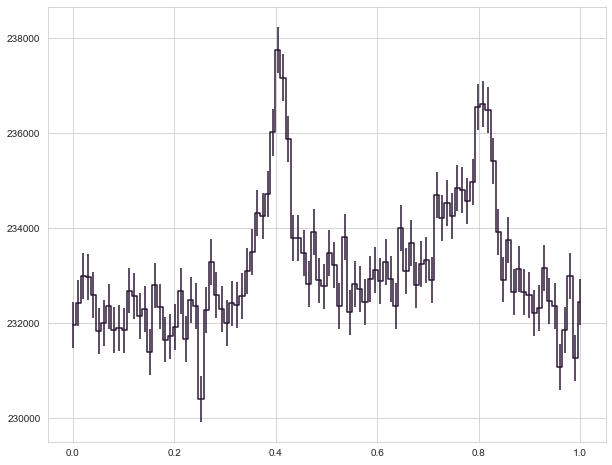

In [51]:
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=8)
pal = sns.color_palette()

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.errorbar(np.linspace(0, 1, 100), results['Profile'], yerr=np.sqrt(results['Profile']),
           drawstyle='steps-mid', label='barycor_unaccelerated')

## re-execute barycorr

### execute full data

In [83]:
orbitfile = "../../test/glg_poshist_all_220315_v00.fit"
orbit = fits.open("../../test/glg_poshist_all_220315_v00.fit")
mjdref = orbit[1].header['mjdrefi'] + orbit[1].header['mjdreff']
mjd = (time/86400) + mjdref

delta_t = barycor(mjd, ra=83.883225, dec=22.014458333333334,
                   orbit=orbitfile,
                   jplephem="../barycor/de421.bsp")


### Plot the variation of delta time

<ErrorbarContainer object of 3 artists>

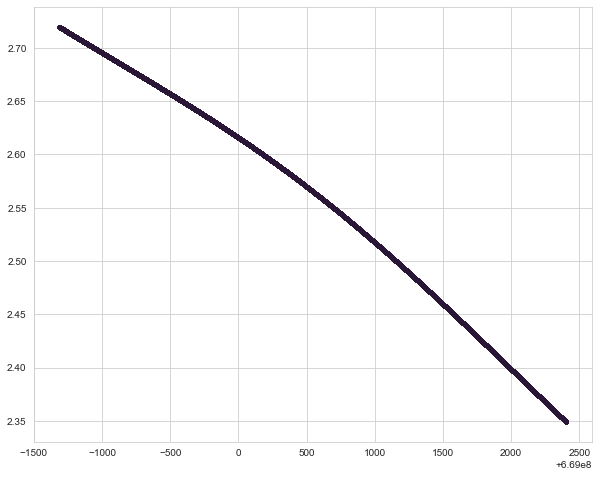

In [85]:
delta_t_unaccelerated = delta_t
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.errorbar(time, delta_t_unaccelerated, fmt='.', label='delta time of each photon')

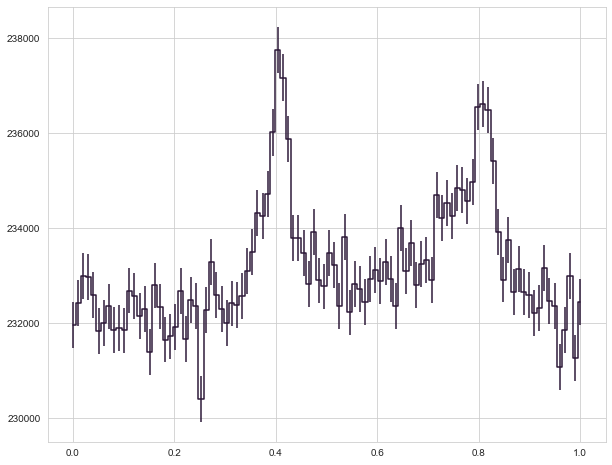

In [86]:
# fold those photons
results = ffold(time+delta_t_unaccelerated, pepoch=mjd2met(pepoch,telescope='fermi'),
                f0=f0, f1=f1,f2=f2,
                bin=100, pepochformat='met', telescope='fermi')
fig, ax = plt.subplots(1,1, figsize=(10, 8))
profile_unaccelerated = results['Profile']
ax.errorbar(np.linspace(0, 1, 100), profile_unaccelerated, yerr=np.sqrt(profile_unaccelerated),
           drawstyle='steps-mid', label='barycor_unaccelerated')
plt.show()

### Draw photons in time series and barycor

In [92]:
hdulist = fits.open("../../test/gbmCrab_2022-03-15_01z.fits.gz")
time = hdulist[1].data.field("TIME")
tdb = hdulist[1].data.field("TDB")
N_seg = int(time.size/60)
time_sample = np.linspace(time.min(), time.max(), N_seg)

orbitfile = "../../test/glg_poshist_all_220315_v00.fit"
orbit = fits.open("../../test/glg_poshist_all_220315_v00.fit")
mjdref = orbit[1].header['mjdrefi'] + orbit[1].header['mjdreff']
mjd_sample = (time_sample/86400) + mjdref

delta_t = barycor(mjd_sample, ra=83.883225, dec=22.014458333333334,
                  orbit=orbitfile,
                  jplephem="../barycor/de421.bsp")
delta_t_accelerated = delta_t

<ErrorbarContainer object of 3 artists>

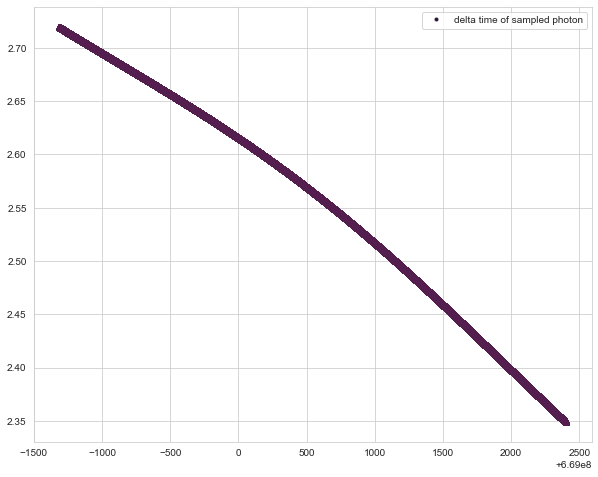

In [93]:
%matplotlib inline
fig, (ax1) = plt.subplots(1,1, figsize=(10, 8))
ax1.errorbar(time_sample, delta_t_accelerated, fmt='.', label='delta time of sampled photon')
plt.legend()

from scipy.interpolate import interp1d
f = interp1d(time_sample, delta_t, kind='quadratic')
ax1.errorbar(time, f(time), fmt='^', label='delta time by interpolation')

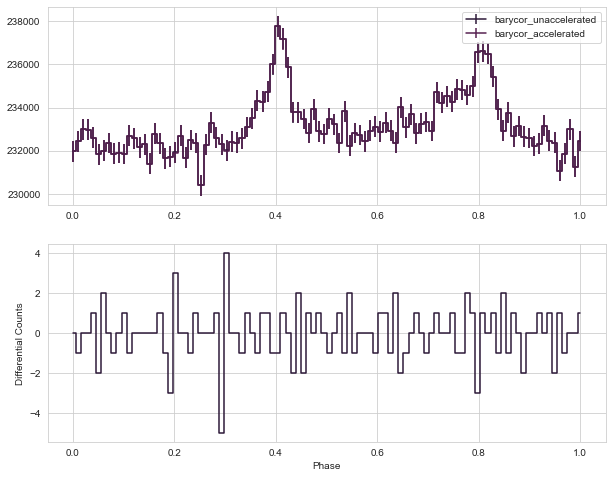

In [100]:
# fold those photons
delta_t_interped = f(time)
results = ffold(time+delta_t_interped, pepoch=mjd2met(pepoch,telescope='fermi'),
                f0=f0, f1=f1,f2=f2,
                bin=100, pepochformat='met', telescope='fermi')
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax.errorbar(np.linspace(0, 1, 100), results['Profile'], yerr=np.sqrt(results['Profile']),
           drawstyle='steps-mid', label='barycor_unaccelerated')
ax.errorbar(np.linspace(0, 1, 100), profile_unaccelerated, yerr=np.sqrt(profile_unaccelerated),
           drawstyle='steps-mid', label='barycor_accelerated')
ax.legend()

ax2.errorbar(np.linspace(0, 1, 100), results['Profile']-profile_unaccelerated,
             drawstyle='steps-mid')
ax2.set_xlabel("Phase")
ax2.set_ylabel("Differential Counts")
plt.show()